In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Simple 2D grid environment
class GridWorld:
    def __init__(self, size=16):
        self.size = size
        self.reset()

    def reset(self):
        self.agent = np.array([self.size//2, self.size//2])
        self.goal = np.array([np.random.randint(self.size), np.random.randint(self.size)])
        return self.render()

    def step(self, action):
        if action == 0: self.agent[0] -= 1
        elif action == 1: self.agent[0] += 1
        elif action == 2: self.agent[1] -= 1
        elif action == 3: self.agent[1] += 1

        self.agent = np.clip(self.agent, 0, self.size-1)

        reward = -0.01
        done = False
        if np.array_equal(self.agent, self.goal):
            reward = 1.0
            done = True

        return self.render(), reward, done

    def render(self):
        grid = np.zeros((self.size, self.size))
        grid[self.goal[0], self.goal[1]] = 1.0
        grid[self.agent[0], self.agent[1]] = 0.5
        return grid


**Note: This is a simplified nano version of the Agentic AI**


 

In [25]:
class PerceptionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        # lightweight spatial attention (policy → attention map)
        self.attn_conv = nn.Conv2d(1, 1, 1)

    def forward(self, x, spatial_modulation):
        x = F.relu(self.conv1(x))

        # produce attention mask from modulation vector
        B, _, H, W = x.shape
        attn = spatial_modulation.view(B, 1, H, W)
        attn = torch.sigmoid(self.attn_conv(attn))

        x = x * attn  # spatial adaptive perception

        x = F.relu(self.conv2(x))
        return torch.flatten(x, 1)


In [26]:
class Expert(nn.Module):
    def __init__(self, in_dim, hidden_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.fc(x)

class PolicyMoE(nn.Module):
    def __init__(self, feature_dim=64*16*16):
        super().__init__()
        self.expert1 = Expert(feature_dim)
        self.expert2 = Expert(feature_dim)

        self.gate = nn.Sequential(
            nn.Linear(feature_dim, 2),
            nn.Softmax(dim=-1)
        )

        self.action_head = nn.Linear(128, 4)
        self.modulation_head = nn.Linear(128, 16*16)  # spatial modulation map

    def forward(self, features):
        gate_weights = self.gate(features)

        e1 = self.expert1(features)
        e2 = self.expert2(features)

        mixture = gate_weights[:,0:1] * e1 + gate_weights[:,1:2] * e2

        action_logits = self.action_head(mixture)
        modulation = self.modulation_head(mixture)
        return action_logits, modulation


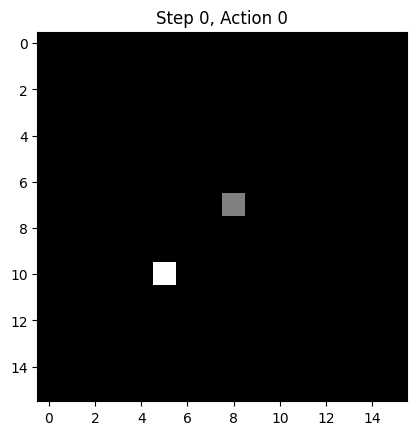

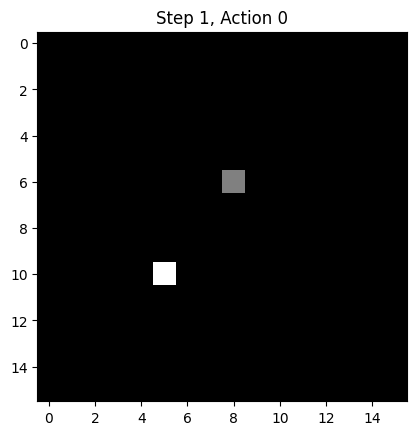

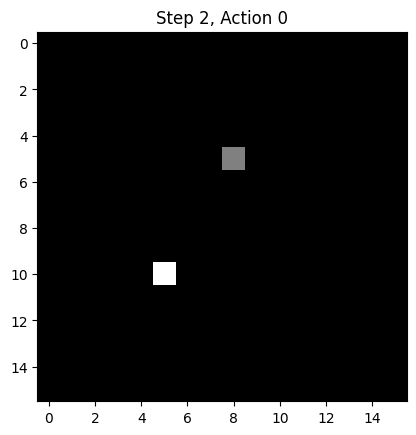

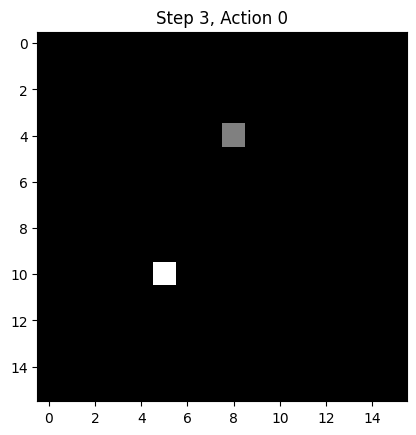

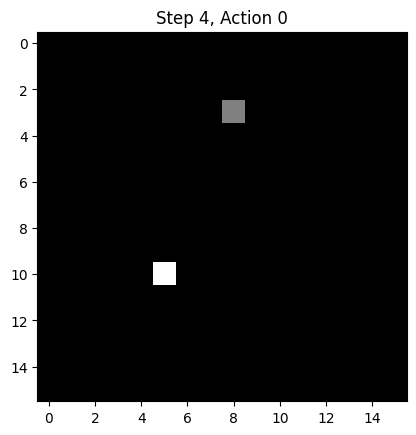

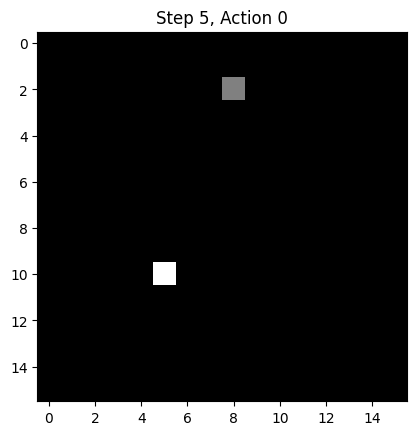

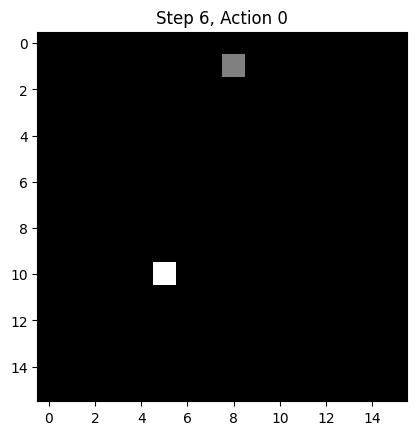

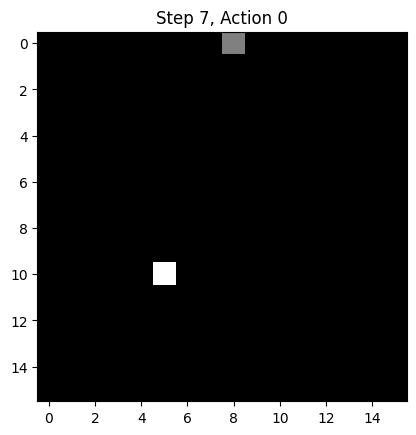

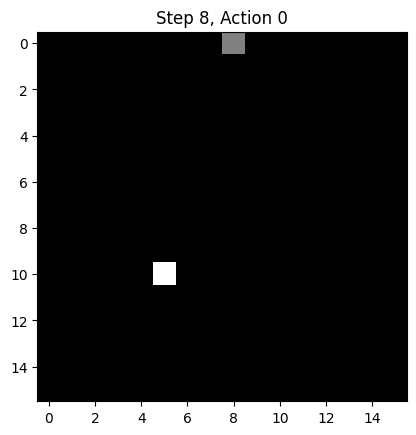

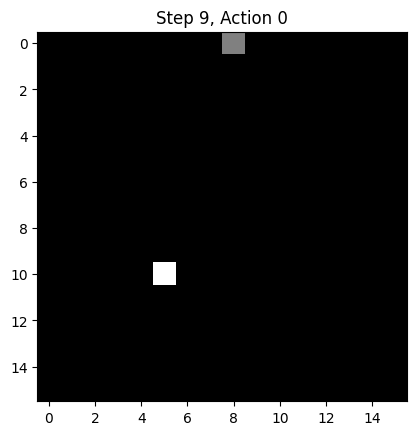

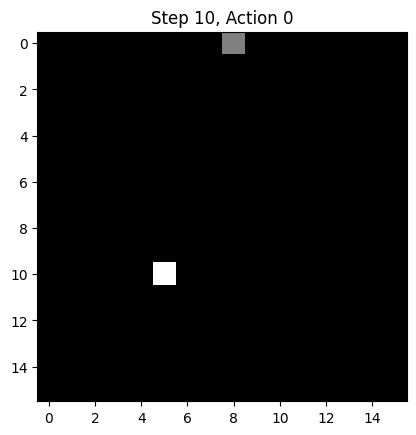

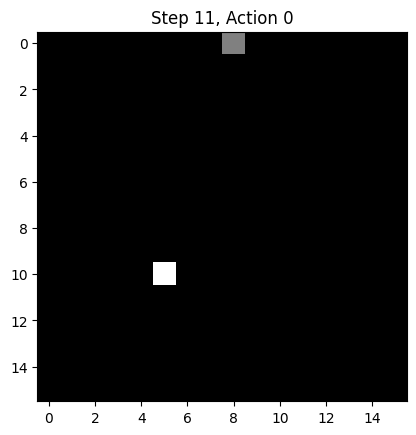

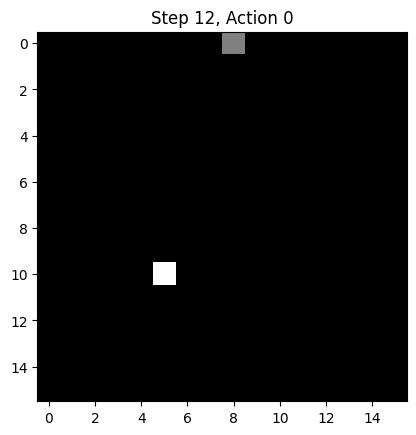

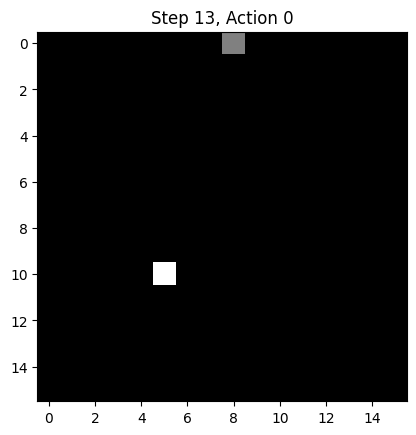

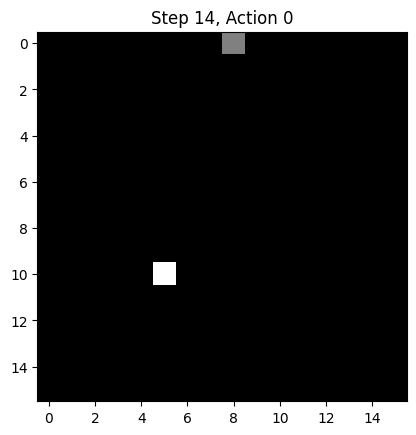

In [27]:
env = GridWorld(size=16)

perception = PerceptionCNN()
policy = PolicyMoE()

state = torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
modulation = torch.zeros((1, 16*16))  # start neutral

for t in range(15):
    features = perception(state, modulation)
    action_logits, modulation = policy(features)

    action = torch.argmax(action_logits).item()

    next_state_np, _, _ = env.step(action)

    state = torch.tensor(next_state_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    plt.imshow(next_state_np, cmap='gray')
    plt.title(f"Step {t}, Action {action}")
    plt.show()
